## Predicting Employee Attrition (Google Advanced Analytics Certificate Capstone Project)

### Import packages and load dataset

In [1]:
# Importing packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

In [2]:
# Loading dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Displaying first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data Exploration (cleaning and initial EDA)

In [3]:
# Gathering basic info about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Gathering descriptive statistics about the data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
# Displaying all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# Renaming columns
df0 = df0.rename(columns={'average_montly_hours':'average_monthly_hours',
                          'Work_accident':'work_accident',
                         'Department':'department',
                         'time_spend_company':'tenure'})

# Displaying all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
# Checking for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
# Checking for duplicates
df0.duplicated().sum()

np.int64(3008)

In [9]:
# Inspecting some rows containing duplicates
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
# Dropping duplicates and saving resulting dataframe as a new variable
df = df0.drop_duplicates()

# Displaying first few rows of new dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<Axes: xlabel='tenure'>

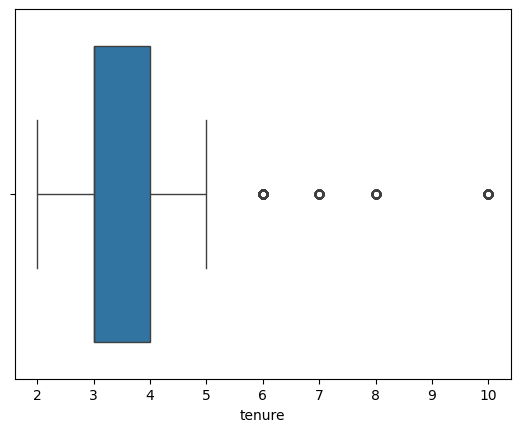

In [11]:
# Creating a boxplot to visualize distribution of `tenure` and detect any outliers
sns.boxplot(data=df, x='tenure')

In [12]:
# Determining the number of rows containing outliers
percentile25 = df['tenure'].quantile(0.25)
percentile75 = df['tenure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

outliers = df[(df['tenure'] > upper_limit) | (df['tenure'] < lower_limit)]

len(outliers)

824

In [13]:
# Getting numbers of people who left vs. stayed
df['left'].value_counts()

left
0    10000
1     1991
Name: count, dtype: int64

In [14]:
# Getting percentages of people who left vs. stayed
df['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

### Data Visualizations

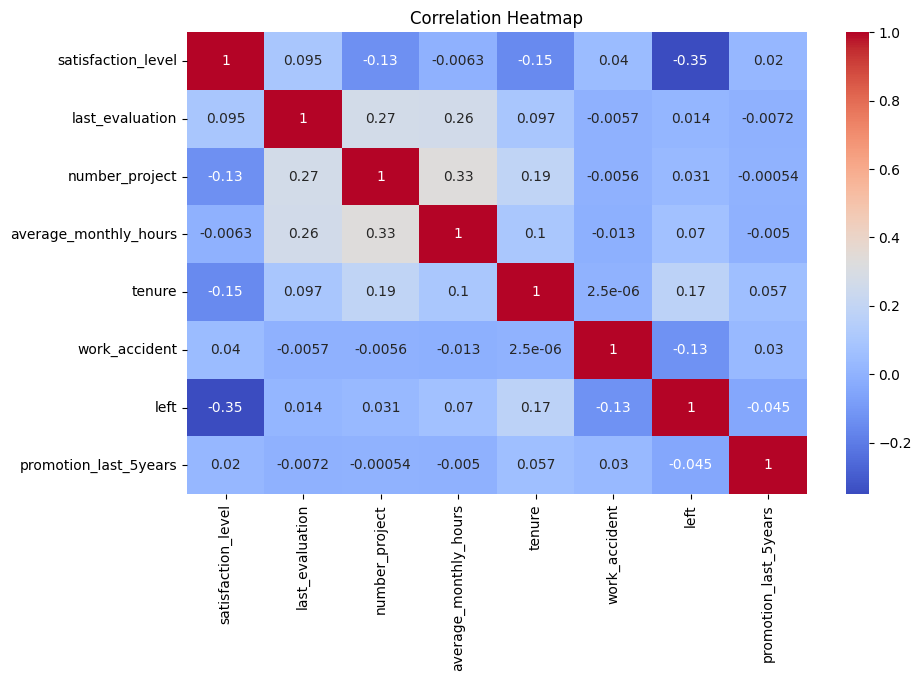

In [15]:
# Creating a heatmap to display correlations between features
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

The correlation heatmap shows that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

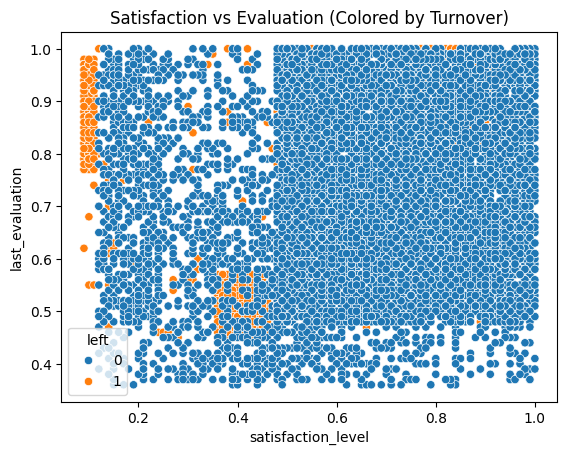

In [16]:
# Creating a scatterplot to visualize the relationship between 'satisfaction_level' and 'last_evaluation'
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='left', data=df)
plt.title("Satisfaction vs Evaluation (Colored by Turnover)")
plt.show()

This scatterplot shows the correlation between satisfaction level and latest evaluation score. Employees who left reported a low satisfaction level while also receiving high evaluation scores, indicating a high level of burnout.

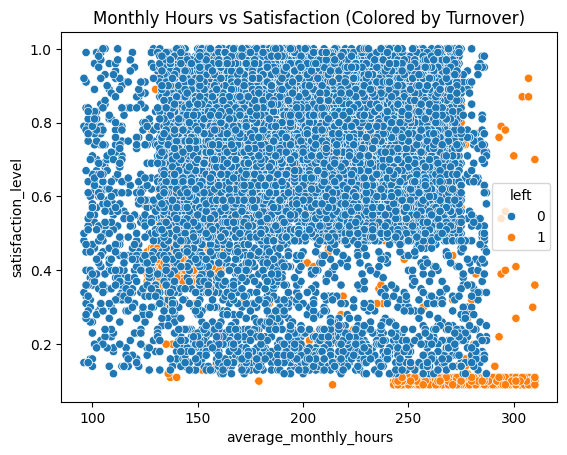

In [17]:
# Creating a scatterplot to visualize the relationship between 'satisfaction_level' and 'average_monthly_hours'
sns.scatterplot(x='average_monthly_hours', y='satisfaction_level', hue='left', data=df)
plt.title("Monthly Hours vs Satisfaction (Colored by Turnover)")
plt.show()

This scatterplot reveals the relationship between satisfaction level and monthly hours. The employees who left had a high amount of average monthly hours, combined with a low satisfaction level, once again indicating symptoms of burnout.

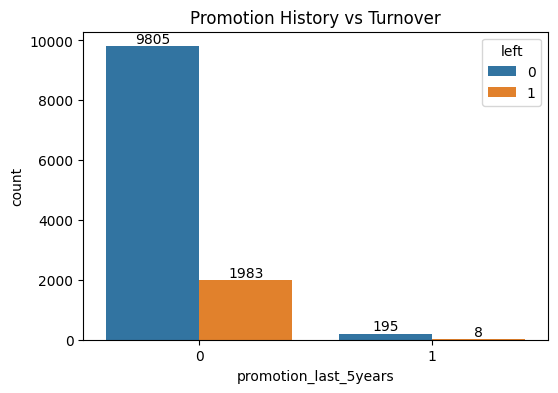

In [18]:
# Creating a count plot of 'promotion_last_5years' and 'left'
plt.figure(figsize=(6,4))
ax = sns.countplot(x='promotion_last_5years', hue='left', data=df)
plt.title("Promotion History vs Turnover")

for container in ax.containers:
    ax.bar_label(container)

plt.show()

This bar plot shows left and retained employees based on if they had a promotion in the last five years.

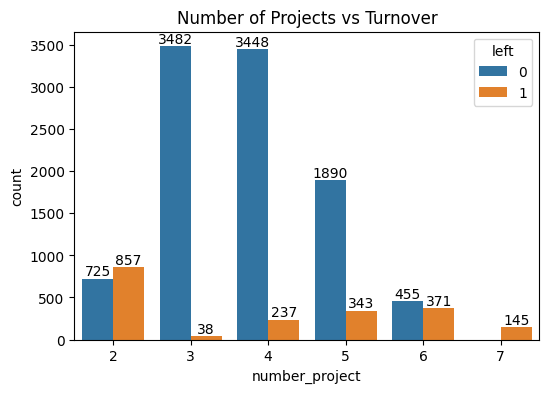

In [20]:
# Creating a count plot of 'number_project' and 'left'
plt.figure(figsize=(6,4))
ax = sns.countplot(x='number_project', hue='left', data=df)
plt.title("Number of Projects vs Turnover")

for container in ax.containers:
    ax.bar_label(container)

plt.show()

This bar plot shows left and retained employees based on the number of projects they have worked on

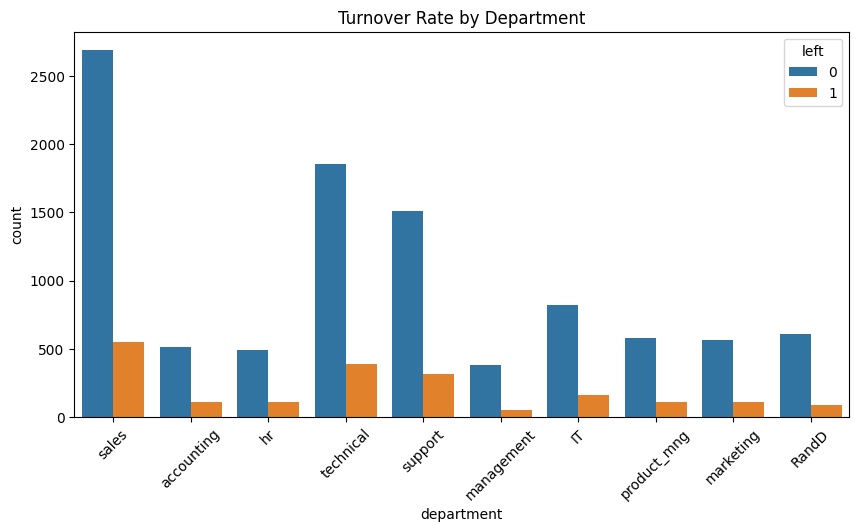

In [21]:
# Creating a count plot of 'department' and 'left'
plt.figure(figsize=(10,5))
sns.countplot(x='department', hue='left', data=df)
plt.title("Turnover Rate by Department")
plt.xticks(rotation=45)
plt.show()

This barplot reveals turnover rate by department. There doesn't seem to be a specific department with a higher relative turnover rate.

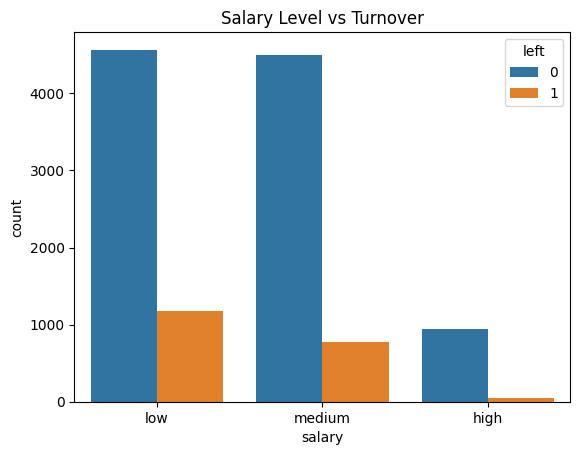

In [22]:
# Creating a count plot of 'salary' and 'left'
sns.countplot(x='salary', hue='left', data=df)
plt.title("Salary Level vs Turnover")
plt.show()

In this barplot, we can see that the highest turnover rate is within the employees with low salary.

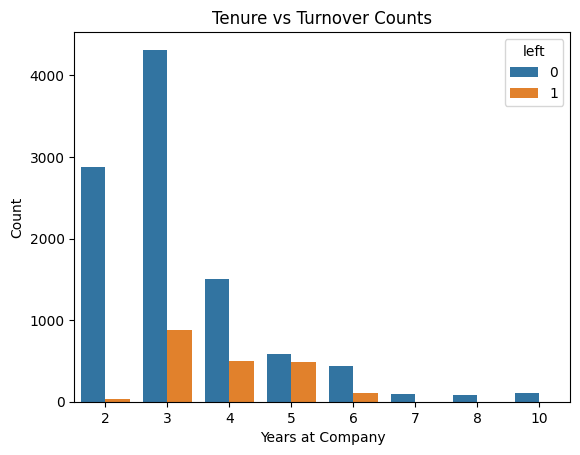

In [23]:
# Creating a count plot of 'tenure' and 'left'
sns.countplot(x='tenure', hue='left', data=df)
plt.title("Tenure vs Turnover Counts")
plt.xlabel("Years at Company")
plt.ylabel("Count")
plt.show()

In this barplot we can see turnover counts by years of tenure. Seems like most employees who leave do it after they have spent 3, 4 or 5 years at the company. There are no employees who left after 7 or more years of tenure.

Seems like employees who leave are also the ones who had a low salary, no promotion in the last 5 years, a high amount of average monthly work hours and reported a low satisfaction level. Based on this information, employees are leaving mostly due to burnout. There doesn't seem to be any pattern related to specific departments.

### Model Building

In [24]:
# Separating target and features
y = df['left']
X = df.drop('left', axis=1)

In [25]:
# Encoding categorical features
X['salary'] = (
    X['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

X = pd.get_dummies(X, drop_first=False)

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

In [27]:
# Setting parameters and doing a grid search for Random Forest model
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [None, 2, 5, 8],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 8],
             'n_estimators': [200, 300, 500]}

scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

rf_gs = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [28]:
# Fitting the model to the training data
rf_gs.fit(X_train, y_train)

,estimator,RandomForestC...andom_state=0)
,param_grid,"{'max_depth': [None, 2, ...], 'max_features': [1.0], 'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,"['accuracy', 'recall', ...]"
,n_jobs,None
,refit,'roc_auc'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [29]:
# Checking the best ROC AUC score determined by the grid search
rf_gs.best_score_

np.float64(0.9803389041397347)

In [30]:
# Checking the best parameters determined by the grid search
rf_gs.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 500}

In [31]:
# Checking the stats of the Random Forest model on the test data
preds = rf_gs.best_estimator_.predict(X_test)

auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

table = pd.DataFrame({'model': 'Random Forest',
                      'precision': [precision], 
                      'recall': [recall],
                      'f1': [f1],
                      'accuracy': [accuracy],
                      'AUC': [auc] })
  
table

,model,precision,recall,f1,accuracy,AUC
0,Random Forest,0.957672,0.909548,0.93299,0.978324,0.950776


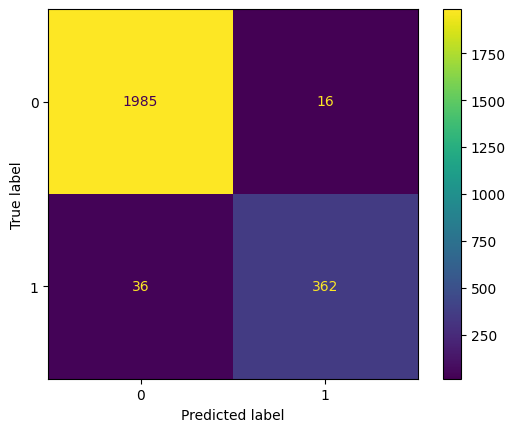

In [32]:
# Creating a confusion matrix of the results of the Random Forest model
cm = confusion_matrix(y_test, preds, labels=rf_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_gs.classes_)
disp.plot(values_format='')

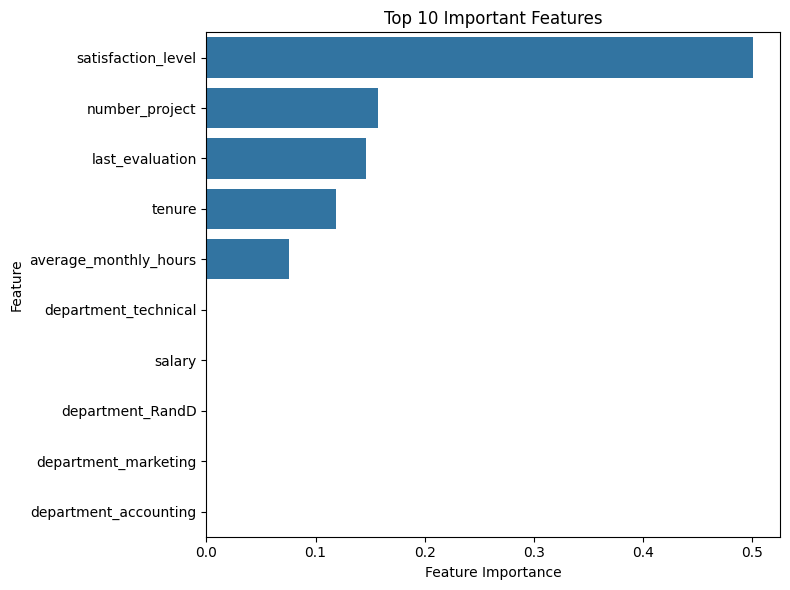

In [33]:
# Checking the feature importance of the Random Forest model
importances = pd.Series(rf_gs.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [34]:
# Setting parameters and doing a grid search for XGBoost model
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4, 6],
               'min_child_weight': [3, 5],
               'learning_rate': [0.1, 0.2, 0.3],
               'n_estimators': [100,200,300],
               'subsample': [0.7],
               'colsample_bytree': [0.7]}

scoring = {'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'}

xgb_gs = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [35]:
# Fitting the model to the training data
xgb_gs.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.7], 'learning_rate': [0.1, 0.2, ...], 'max_depth': [4, 6], 'min_child_weight': [3, 5], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': make_scorer(f...ro_division=0), 'precision': make_scorer(p...ro_division=0), 'recall': make_scorer(r...ro_division=0), ...}"
,n_jobs,None
,refit,'roc_auc'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [36]:
# Checking the best ROC AUC score determined by the grid search
xgb_gs.best_score_

np.float64(0.9840198247347359)

In [37]:
# Checking the best parameters determined by the grid search
xgb_gs.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.7}

In [38]:
# Checking the stats of the XGBoost model on the test data
preds = xgb_gs.best_estimator_.predict(X_test)

auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

table = pd.DataFrame({'model': 'XGBoost',
                      'precision': [precision], 
                      'recall': [recall],
                      'f1': [f1],
                      'accuracy': [accuracy],
                      'AUC': [auc] })
  
table

,model,precision,recall,f1,accuracy,AUC
0,XGBoost,0.965333,0.909548,0.936611,0.979575,0.951525


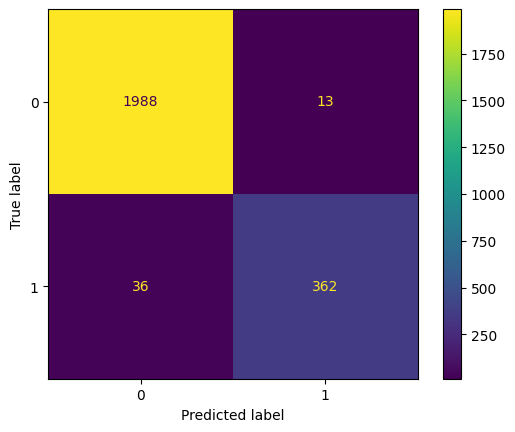

In [39]:
# Creating a confusion matrix of the results of the XGBoost model
cm = confusion_matrix(y_test, preds, labels=xgb_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_gs.classes_)
disp.plot(values_format='')

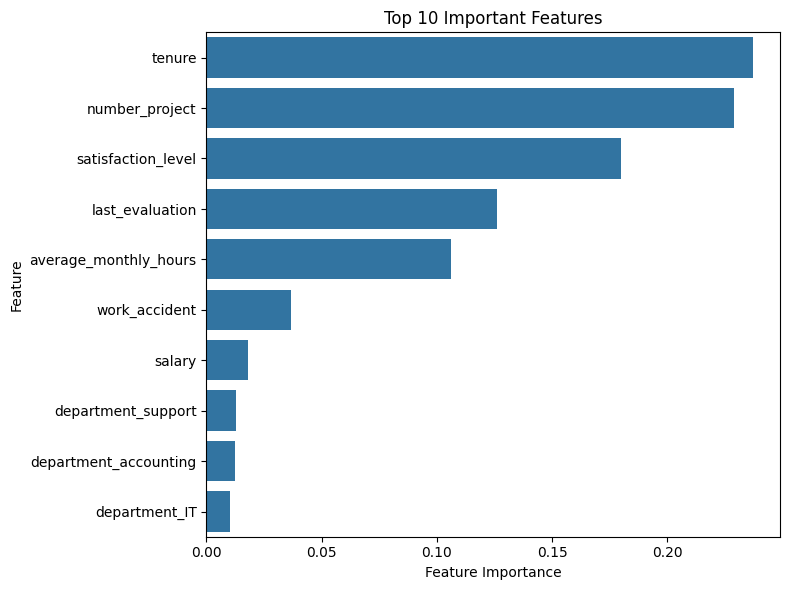

In [40]:
# Checking the feature importance of the XGBoost model
importances = pd.Series(xgb_gs.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()